I'll be trying to use a VGG16 (and some others) using Transfer learning to try and recognise the faces of my 109 mangaset!

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image 
from matplotlib.pyplot import imread
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import math
import copy
%matplotlib inline

from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

import keras.backend as K
from keras import optimizers
from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator



In [2]:
K.clear_session()
K.set_image_data_format( 'channels_last' ) 
nrow = 200
ncol = 200

In [3]:
# import os
# import shutil

# src_folder = '../../Data/checking_validity/face_train'
# textFileNames = os.listdir(src_folder)
# dst_folder = '../../Data/checking_validity/face_test'


# for i in range(len(textFileNames)):

#     src_dir = textFileNames[i]
#     files = os.listdir(src_folder+ '/' +src_dir)

#     print(files)
    
#     dir_exists = os.path.isdir(dst_folder+'/'+src_dir)
#     if not dir_exists:
#         print(dst_folder)
#         os.makedirs(dst_folder+'/'+src_dir)
#     else:
#         print('save file in' + dst_folder+'/'+src_dir)
        
#     for j in range(round(len(files) / 4)):
#         src = src_folder+'/'+src_dir+'/'+files[j]
#         print(src)
#         dst = dst_folder+'/'+src_dir+'/'+files[j]
#         shutil.move(src, dst)

In [4]:
#custom parameters
# 10 Names, 10 classes
src_folder = '../../Data/checking_validity/face_train'
textFileNames = os.listdir(src_folder)

nb_class = len(textFileNames)
hidden_dim = 512

vgg16 = VGGFace(include_top=False, input_shape=(nrow, ncol,3))
for layer in vgg16.layers:
    layer.trainable = True

last_layer = vgg16.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
x = Dense(hidden_dim, activation='relu', name='fc8')(x)
x = Dense(hidden_dim/2, activation='relu', name='fc9')(x)
out = Dense(nb_class, activation='softmax', name='fc10')(x)
vgg16 = Model(vgg16.input, out)
vgg16.summary()

# resnet = VGGFace(model='resnet50',include_top=False, input_shape=(nrow, ncol, 3))
# for layer in resnet.layers:
#     layer.trainable = True

# last_layer = resnet.get_layer('avg_pool').output
# x = Flatten(name='flatten')(last_layer)
# x = Dense(hidden_dim, activation='relu', name='fc6')(x)
# x = Dense(hidden_dim, activation='relu', name='fc7')(x)
# out = Dense(nb_class, activation='softmax', name='fc8')(x)
# resnet = Model(resnet.input, out)
# resnet.summary()

# senet = VGGFace(model='senet50',include_top=False, input_shape=(nrow, ncol, 3))
# for layer in senet.layers:
#     layer.trainable = True

# last_layer = senet.get_layer('avg_pool').output
# x = Flatten(name='flatten')(last_layer)
# x = Dense(hidden_dim, activation='relu', name='fc6')(x)
# x = Dense(hidden_dim, activation='relu', name='fc7')(x)
# out = Dense(nb_class, activation='softmax', name='fc8')(x)
# senet = Model(senet.input, out)
# senet.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 200, 200, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 200, 200, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 100, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 100, 100, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 50, 128)       0     

In [5]:
import os
datasetDescriptor = '../../Data/checking_validity/face_train'
textFileNames = os.listdir(datasetDescriptor)
batch_size = 10
print(textFileNames)

['Luffy', 'Nami', 'Sanji', 'Usopp', 'Zoro']


In [6]:
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

In [7]:
test_data_dir = '../../Data/checking_validity/face_test'
test_datagen = ImageDataGenerator(rescale=1/255,
                                   # Add rotation 
                                   rotation_range=20)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 397 images belonging to 5 classes.


In [8]:
train_data_dir = '../../Data/checking_validity/face_train'
train_datagen = ImageDataGenerator(rescale=1/255,
                                   # Add rotation
                                   rotation_range=20)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 718 images belonging to 5 classes.


In [9]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
class_weights = dict(enumerate(class_weights))


In [10]:
print(textFileNames)

['Luffy', 'Nami', 'Sanji', 'Usopp', 'Zoro']


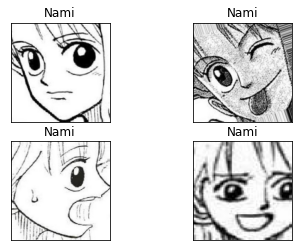

In [11]:
batch_shape = (batch_size,vgg16.input_shape[1] , 
               vgg16.input_shape[2], 
               vgg16.input_shape[3])

X = np.zeros(batch_shape)
y = np.zeros(batch_size)


X,y = train_generator.next()
nplot = 4 

for i in range(nplot):    
    plt.subplot(2,nplot/2,i+1)
    disp_image(X[i,:,:,:])
    title = (textFileNames[int(y[i])])
    plt.title(title)

In [12]:
vgg16.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.Adam(lr=1e-5),
                         metrics=['accuracy'])

steps_per_epoch = train_generator.n // batch_size 
validation_steps = test_generator.n // batch_size 

history_vgg16 = vgg16.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=test_generator,
    validation_steps=validation_steps,
    class_weight=class_weights)

Epoch 1/15
71/71 [==============================] - 32s 446ms/step - loss: 1.2710 - accuracy: 0.5593 - val_loss: 0.5642 - val_accuracy: 0.8000
Epoch 2/15
71/71 [==============================] - 29s 406ms/step - loss: 0.2705 - accuracy: 0.9197 - val_loss: 0.4414 - val_accuracy: 0.8744
Epoch 3/15
71/71 [==============================] - 41s 577ms/step - loss: 0.1324 - accuracy: 0.9562 - val_loss: 0.3292 - val_accuracy: 0.8846
Epoch 4/15
71/71 [==============================] - 89s 1s/step - loss: 0.0698 - accuracy: 0.9746 - val_loss: 0.4314 - val_accuracy: 0.8718
Epoch 5/15
71/71 [==============================] - 84s 1s/step - loss: 0.0371 - accuracy: 0.9929 - val_loss: 0.2642 - val_accuracy: 0.9179
Epoch 6/15
71/71 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9929

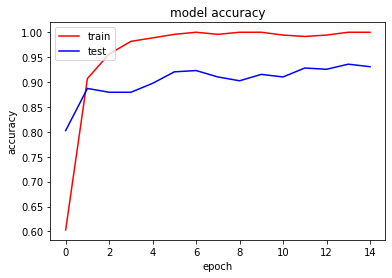

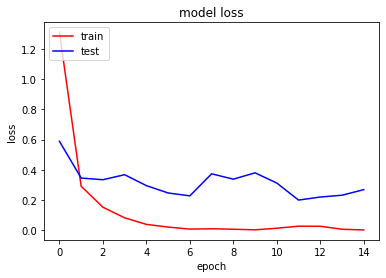

In [13]:
plt.plot(history_vgg16.history['accuracy'],'r')
plt.plot(history_vgg16.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history_vgg16.history['loss'],'r')
plt.plot(history_vgg16.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1]:
X,y = test_generator.next()

y_pred = vgg16.predict(X)

#print(y)

y_true = []

#for i in range(len(y)):
#    filler = np.zeros(nb_class)
#    location = y[i]
#    filler[int(location)] = 1
#    y_true.append(filler)


y_true = np.matrix(y_true)
y_pred = y_pred.round()

print('\n')
print(classification_report(y_true, y_pred))

cf = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

print(cf)
print(accuracy_score(y_true, y_pred) * 100) 

NameError: name 'test_generator' is not defined

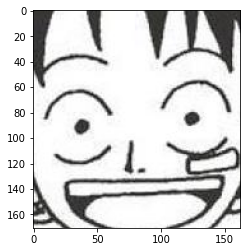

['Luffy', 'Nami', 'Sanji', 'Usopp', 'Zoro']
[0.08461936 0.00176189 0.00695672 0.6827762  0.22388582]
3
Is the character pictured: Usopp ?


In [15]:
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

img = mpimg.imread('4.jpg')
imgplot = plt.imshow(img)
plt.show()

img = transform.resize(img,(1,nrow,ncol,3))
# img /= 255
y_pred = vgg16.predict(img)

test_data_dir = '../../Data/checking_validity/face_test'
list_classes = os.listdir(test_data_dir)

print(list_classes)
print(y_pred[0])

ind = np.argmax(y_pred[0])
print(ind)
print("Is the character pictured: " + list_classes[ind] + " ?")

In [16]:
# resnet.compile(loss='sparse_categorical_crossentropy',
#                          optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#                          metrics=['accuracy'])

# steps_per_epoch = train_generator.n // batch_size 
# validation_steps = test_generator.n // batch_size 
# nepochs = 50

# resnet.fit_generator(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=nepochs,
#     validation_data=test_generator,
#     validation_steps=validation_steps)

In [17]:
# senet.compile(loss='sparse_categorical_crossentropy',
#                          optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#                          metrics=['accuracy'])

# steps_per_epoch = train_generator.n // batch_size 
# validation_steps = test_generator.n // batch_size 
# nepochs = 20

# senet.fit_generator(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=nepochs,
#     validation_data=test_generator,
#     validation_steps=validation_steps)